# Beyond Naïve Bayes: complex Bayesian Network Architectures
Build two or three Bayes networks of more complex architecture for (a smaller version of) this data set, increasing the number
of connections among the nodes. Construct one of them semi-manually (e.g use K2 algorithm and vary the maximum number of parents), and two others – using Weka’s algorithms for learning Bayes net construction (e.g. use TAN or Hill Climbing algorithms). Run the experiments described in item 5 on these new Bayes network architectures. Record, compare and analyse the outputs, in the light of the previous conclusions about the given data. 

# To go in submission notebook

In [39]:
from Scripts import helperfn as hf
from Scripts import pixelFinder as pf 
from Scripts import downsample as ds
from Scripts.NaiveBayse import NaiveBayseGaussian as nbg
from Scripts import bayseNet as bn
from Scripts import confusionMatrix as cm
from Scripts import plotScripts as ps
%load_ext autoreload
%autoreload 2

from sklearn.model_selection import train_test_split
import networkx as nx
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.estimators import BayesianEstimator, HillClimbSearch, ExhaustiveSearch, K2Score, MaximumLikelihoodEstimator, BicScore, BDeuScore



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Preprocess data
### Get equal width binned data and labels

In [17]:
X, y = hf.get_data(4)
X = hf.to_ewb(X)

Equal Width Binning Data...
Progress: [####################] 100.0%


#### Select most predicitve pixels

In [3]:
pixels = pf.get_top_pixels(2304, downscaled=False)

Loading...
Progress: [####################] 100.0%


In [4]:
selected_pixels = pf.grab_n_pixels(pixels, 5)

### Prepare data for manual naive model

In [18]:
x_bal_pixels, y_pixels = hf.balance_by_class(X, y)
y_pixels.columns = ['y']
X_bal = np.take(x_bal_pixels, selected_pixels[5], axis=1)
X_train, x_test, y_train, y_test = train_test_split(X_bal, y_pixels, random_state=0, test_size=0.2)
X_pixels = X_train.join(y_train)

## Manual Edges
### Build a model manually for 5 pixels using the naive assumption that all non-class nodes are independant

In [20]:
naive_edges = bn.get_naive_edges(selected_pixels[5])
naive_model = bn.model_with_params(X_pixels, naive_edges)

['983', 'y', '1031', '1030', '982', '935']


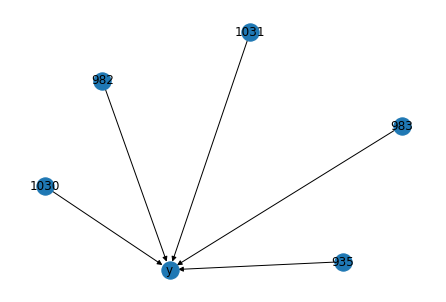

In [21]:
nx.draw(naive_model, with_labels=True)

### Warning: Scoring this model is extremely slow

In [22]:

infer_naive = bn.get_inference_model(naive_model)
naive_score = bn.score_model(infer_naive, x_test, y_test)
print('--- Scoring model Complete ---')

Scoring model...
Progress: [####################] 99.9%


Score:  0.7424242424242424
--- Scoring model Complete ---


## Build networks for each classifier for 5 pixels
### Search for edges and network parameters. Once the model is build score it.
This may take a while, depending on the variable dependencies.

In [8]:
models_inference, scores, train_test_data = bn.build_networks(selected_pixels, ewb=True, balance_by_class=True)


Scoring model...
Progress: [####################] 99.3%


Score:  0.6222222222222222


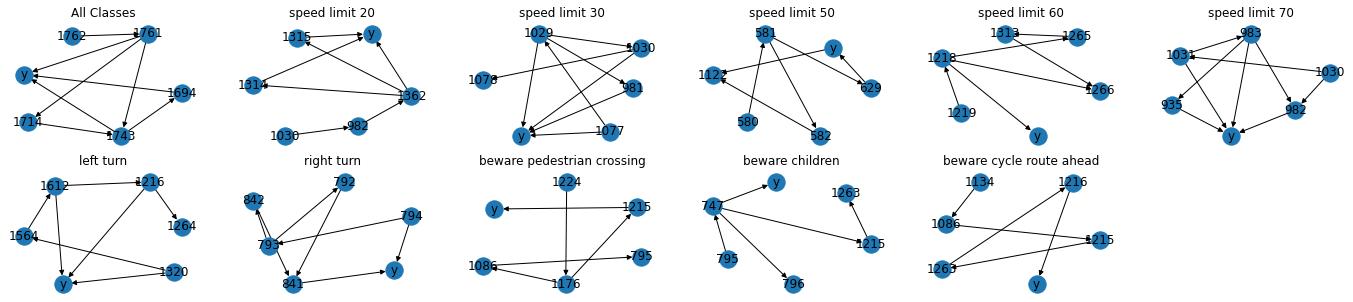

In [41]:

ps.show_models(models_inference[0])

In [44]:
print('-- Local independencies for \'y\' --')
print(models_inference[0][0].local_independencies('y'))
print('---------- Independencies ----------')
print(models_inference[0][0].get_independencies())

-- Local independencies for 'y' --
(y _|_ 1714, 1762 | 1743, 1761, 1694)
---------- Independencies ----------
(1714 _|_ 1694 | 1743)
(1714 _|_ 1762 | 1761)
(1714 _|_ 1694 | 1743, 1762)
(1714 _|_ 1694, y, 1762 | 1743, 1761)
(1714 _|_ 1762 | 1761, 1694)
(1714 _|_ 1762 | 1761, y)
(1714 _|_ 1694, y | 1743, 1761, 1762)
(1714 _|_ y, 1762 | 1743, 1761, 1694)
(1714 _|_ 1694, 1762 | 1743, 1761, y)
(1714 _|_ 1762 | 1761, 1694, y)
(1714 _|_ y | 1743, 1761, 1694, 1762)
(1714 _|_ 1694 | 1743, 1761, y, 1762)
(1714 _|_ 1762 | 1743, 1761, 1694, y)
(1743 _|_ 1762 | 1761)
(1743 _|_ 1762 | 1761, 1694)
(1743 _|_ 1762 | 1761, 1714)
(1743 _|_ 1762 | 1761, y)
(1743 _|_ 1762 | 1761, 1694, 1714)
(1743 _|_ 1762 | 1761, 1694, y)
(1743 _|_ 1762 | 1761, y, 1714)
(1743 _|_ 1762 | 1761, 1694, y, 1714)
(1762 _|_ 1694 | 1743)
(1762 _|_ 1743, 1694, y, 1714 | 1761)
(1762 _|_ 1694 | 1743, 1714)
(1762 _|_ 1694, y, 1714 | 1743, 1761)
(1762 _|_ 1743, y, 1714 | 1761, 1694)
(1762 _|_ 1743, 1694, y | 1761, 1714)
(1762 _|_ 1743

## Confusion matrix for training and testing 5 pixels
#### Observations:

1. Some degree of overfitting is occuring for 'speed limit 20', 'turn left', and beware cycle route ahead
2. Most of the classifiers are not particularly accurate


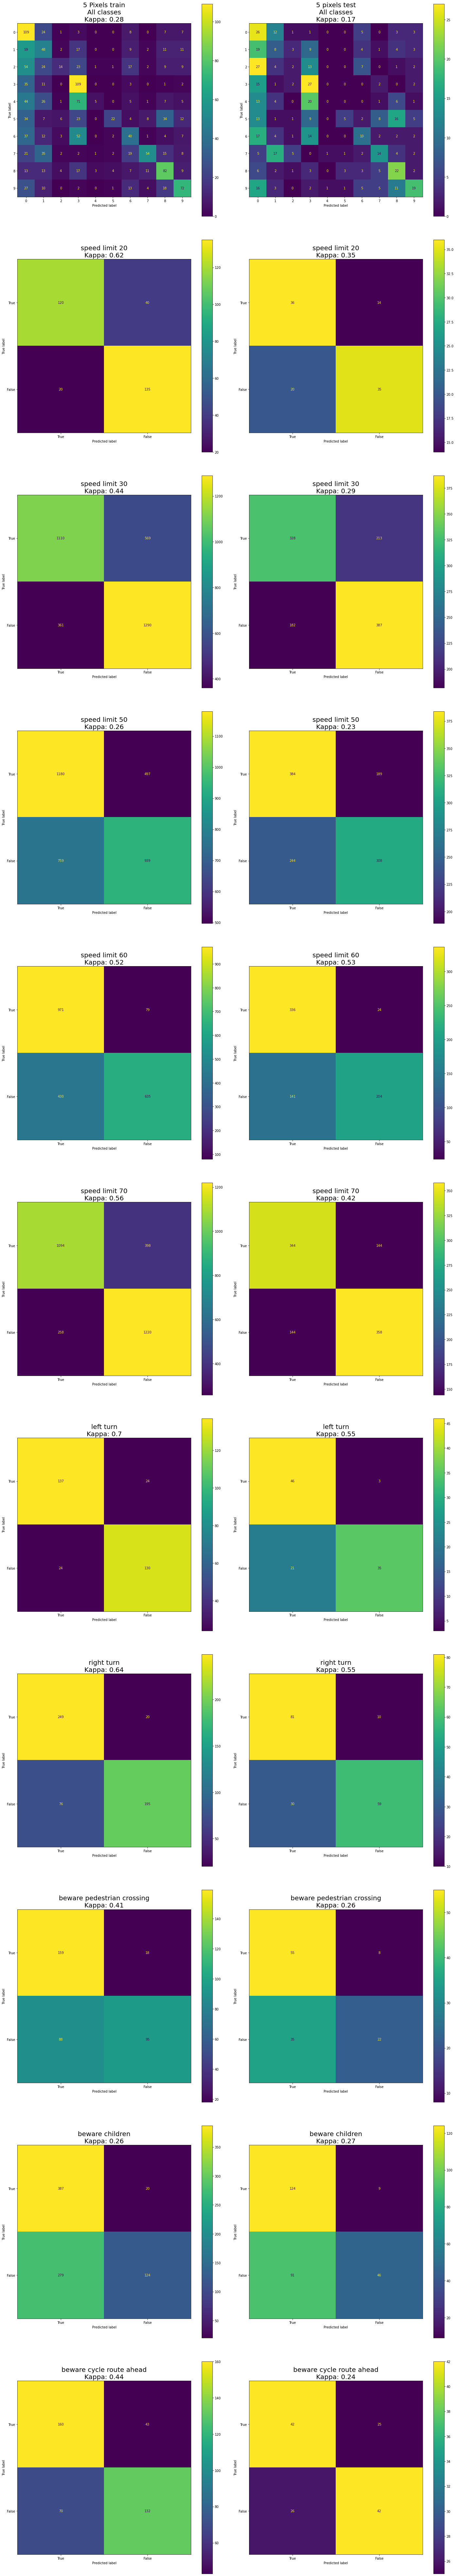

In [45]:

train_conf, test_conf = bn.bayse_net_confusion_matrices(scores, train_test_data)
cm.multi_show_confusion_matrix([train_conf, test_conf], kappas=[cm.kappa(train_conf), cm.kappa(test_conf)], col_labels=['5 Pixels train', '5 pixels test'])

## Build model networks for 10 pixels

In [46]:
selected_pixels = pf.grab_n_pixels(pixels, 10)
ten_models_inference, ten_scores, ten_train_test_data = bn.build_networks(selected_pixels, ewb=True, balance_by_class=True)

Scoring model...
Progress: [####################] 99.3%


Score:  0.7703703703703704


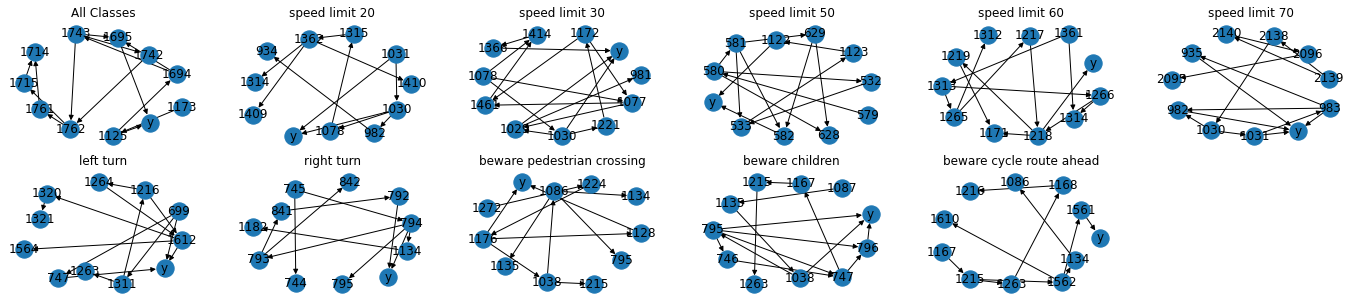

In [48]:
ps.show_models(ten_models_inference)

In [51]:
print('-- Local independencies for \'y\' --')
print(ten_models_inference[0][0].local_independencies('y'))
#print('---------- Independencies ----------')
#print(ten_models_inference[0][0].get_independencies())


-- Local independencies for 'y' --
(y _|_ 1743, 1173, 1762, 1715, 1694, 1714, 1761, 1742 | 1125, 1695)


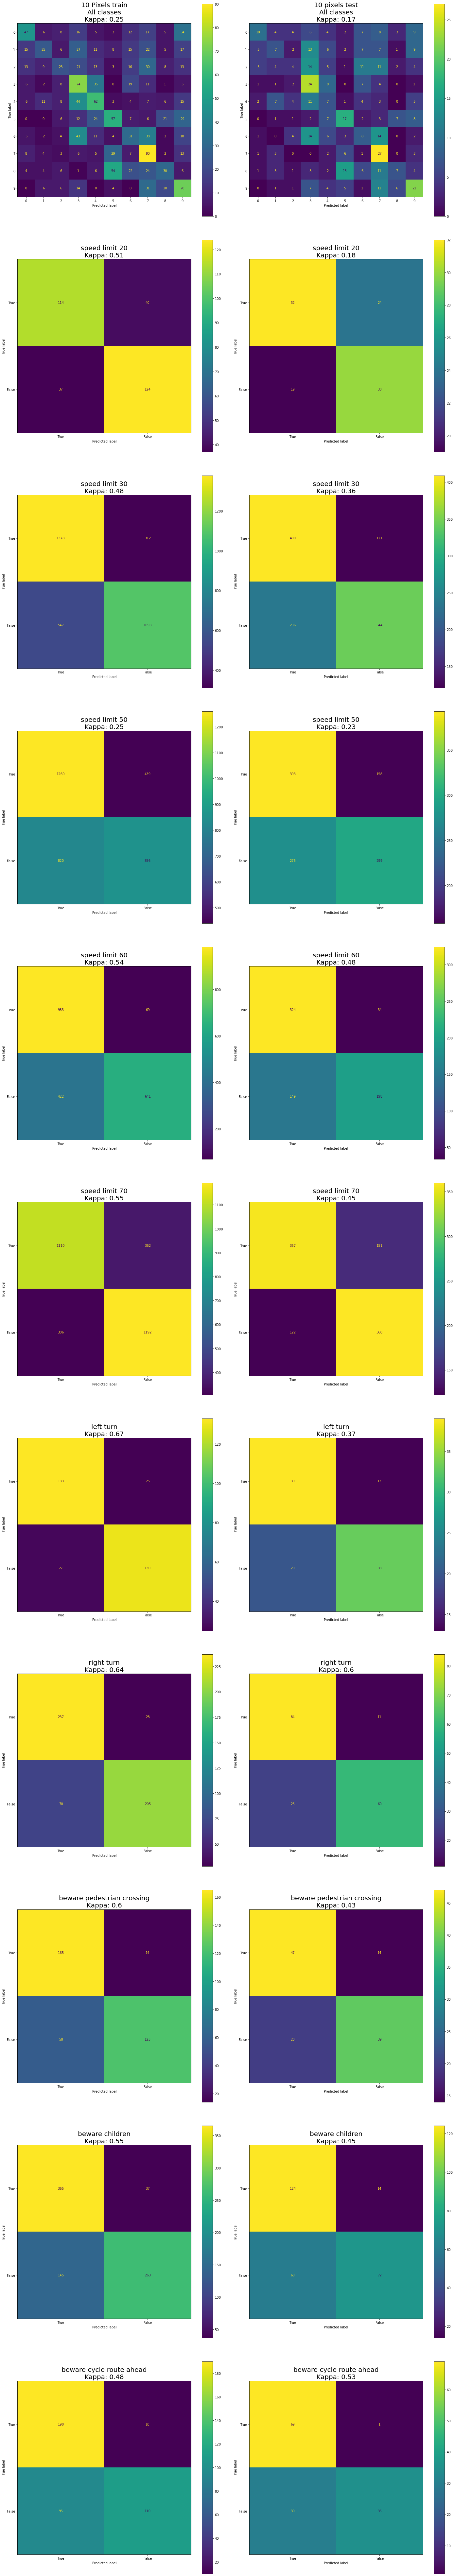

In [52]:
train_conf, test_conf = bn.bayse_net_confusion_matrices(ten_scores, ten_train_test_data)
cm.multi_show_confusion_matrix([train_conf, test_conf], kappas=[cm.kappa(train_conf), cm.kappa(test_conf)], col_labels=['10 Pixels train', '10 pixels test'])

In [ ]:
selected_pixels = pf.grab_n_pixels(pixels, 15)
fifteen_models_inference, fifteen_scores, fifteen_train_test_data = bn.build_networks(selected_pixels, ewb=True, balance_by_class=True)

In [ ]:
ps.show_models(fifteen_models_inference)

In [ ]:
for i in range(len(fifteen_models_inference)):
    print('--', i-1, ' Local independencies for \'y\' --')
    print(fifteen_models_inference[i][0].local_independencies('y'))

In [ ]:
train_conf, test_conf = bn.bayse_net_confusion_matrices(fifteen_scores, fifteen_train_test_data)
cm.multi_show_confusion_matrix([train_conf, test_conf], kappas=[cm.kappa(train_conf), cm.kappa(test_conf)], col_labels=['15 Pixels train', '15 pixels test'])